In [31]:
import os
import pandas as pd
import numpy as np
from librosa import load as lr_load
import librosa as lr
from librosa import amplitude_to_db
from librosa.feature import melspectrogram, mfcc, chroma_stft, spectral_flatness, zero_crossing_rate, tempogram
from librosa.beat import tempo, beat_track
from librosa.feature import spectral_contrast as lf_spectral_contrast
from librosa.feature import spectral_rolloff as lf_spectral_rolloff
from librosa import pyin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import IPython.display as ipd

In [32]:
%reset
import os
import numpy as np
import pandas as pd
import librosa as lr
from IPython.display import display
from librosa import amplitude_to_db
from librosa.feature import chroma_stft, melspectrogram, mfcc, tempogram, zero_crossing_rate
from pydub import AudioSegment
from scipy.io import wavfile

In [33]:
class AudioFeatureExtractor:
    """
    A class for extracting various audio features from an audio signal.

    Attributes:
        None

    Methods:
        mfccs(data, sfreq):
            Extracts Mel-Frequency Cepstral Coefficients (MFCCs) from the audio signal.

        calculate_spectrograms(audio_clips, n_fft=2048, hop_length=512, win_length=None):
            Calculates spectrograms from a list of audio clips.

        calculate_spectral_features(spectrograms):
            Calculates spectral features (bandwidth and centroid) from a list of spectrograms.

        calculate_spectral_contrast(data, sr, n_fft=2048, hop_length=512):
            Calculates spectral contrast from the audio signal.

        calculate_tonnetz(data, sr):
            Calculates tonnetz features from the audio signal.

        calculate_spectral_rolloff(data, sr, roll_percent=0.85, n_fft=2048, hop_length=512):
            Calculates spectral rolloff from the audio signal.

        calculate_chroma_features(data, sr, n_fft=2048, hop_length=512):
            Calculates chroma features from the audio signal.

        calculate_mel_spectral_contrast(data, sr, n_fft=2048, hop_length=512):
            Calculates mel spectrogram and its contrast from the audio signal.

        calculate_spectral_flatness(data, sr, n_fft=2048, hop_length=512):
            Calculates spectral flatness from the audio signal.

        zero_crossing_rate_features(data, n_fft=2048, hop_length=512):
            Calculates zero-crossing rate from the audio signal.

        calculate_tempogram(data, sr):
            Calculates tempogram from the audio signal.

        calculate_polyphonic_pitch(data, sr):
            Calculates polyphonic pitch from the audio signal.

        rms_energy_features(data):
            Calculates root mean square (RMS) energy from the audio signal.
    """

    def __init__(self):
        pass

    def mfccs(self, data, sr):
        """
        Extracts Mel-Frequency Cepstral Coefficients (MFCCs) from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.

        Returns:
            dict: A dictionary containing the mean of each MFCC coefficient.
        """
        mfcc_result = mfcc(y=data, sr=sr)
        datadict = {}
        for var in range(len(mfcc_result)):
            datadict[f'mfcc{var + 1}_mean'] = np.mean(mfcc_result[var, :])
        return datadict

    def calculate_spectrograms(self, audio_clips, n_fft=2048, hop_length=512, win_length=None):
        """
        Calculates spectrograms from a list of audio clips.

        Parameters:
            audio_clips (list): List of audio clips.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.
            win_length (int): The length of the windowing segments.

        Returns:
            tuple: Two lists - spectrograms and their corresponding dB-scaled versions.
        """
        spectrograms = []
        spectrograms_db = []

        for clip in audio_clips:
            stft_matrix = lr.stft(y=clip, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
            spectrogram = np.abs(stft_matrix)
            spec_db = amplitude_to_db(S=spectrogram, ref=np.max)
            spectrograms.append(spectrogram)
            spectrograms_db.append(spec_db)

        return spectrograms, spectrograms_db

    def calculate_spectral_features(self, spectrograms):
        """
        Calculates spectral features (bandwidth and centroid) from a list of spectrograms.

        Parameters:
            spectrograms (list): List of spectrograms.

        Returns:
            tuple: Two lists - spectral bandwidths and centroids.
        """
        bandwidths = []
        centroids = []

        for spectrogram in spectrograms:
            spec_bw = lr.feature.spectral_bandwidth(S=spectrogram)
            spec_cn = lr.feature.spectral_centroid(S=spectrogram)
            bandwidths.append(spec_bw)
            centroids.append(spec_cn)

        return bandwidths, centroids

    def calculate_spectral_contrast(self, data, sr, n_fft=2048, hop_length=512):
        """
        Calculates spectral contrast from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Spectral contrast features.
        """
        spectral_contrast = lr.feature.spectral_contrast(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)
        return spectral_contrast

    def calculate_tonnetz(self, data, sr):
        """
        Calculates tonnetz features from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.

        Returns:
            numpy.ndarray: Tonnetz features.
        """
        tonnetz = lr.feature.tonnetz(y=data, sr=sr)
        return tonnetz

    def calculate_spectral_rolloff(self, data, sr, roll_percent=0.85, n_fft=2048, hop_length=512):
        """
        Calculates spectral rolloff from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.
            roll_percent (float): Percentage for determining rolloff.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Spectral rolloff features.
        """
        spectral_rolloff = lr.feature.spectral_rolloff(y=data, sr=sr, roll_percent=roll_percent, n_fft=n_fft, hop_length=hop_length)
        return spectral_rolloff

    def calculate_chroma_features(self, data, sr, n_fft=2048, hop_length=512):
        """
        Calculates chroma features from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Chroma features.
        """
        chromagram = chroma_stft(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)
        return chromagram

    def calculate_mel_spectral_contrast(self, data, sr, n_fft=2048, hop_length=512):
        """
        Calculates mel spectrogram and its contrast from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Mel spectrogram contrast features.
        """
        mel_spectrogram = melspectrogram(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)
        mel_spectral_contrast = lr.feature.spectral_contrast(S=mel_spectrogram)
        return mel_spectral_contrast

    def calculate_spectral_flatness(self, data, sr, n_fft=2048, hop_length=512):
        """
        Calculates spectral flatness from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Spectral flatness features.
        """
        flatness = lr.feature.spectral_flatness(y=data, n_fft=n_fft, hop_length=hop_length)
        return flatness

    def zero_crossing_rate_features(self, data, n_fft=2048, hop_length=512):
        """
        Calculates zero-crossing rate from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Zero-crossing rate features.
        """
        zcr = zero_crossing_rate(y=data, frame_length=n_fft, hop_length=hop_length)
        return zcr

    def calculate_tempogram(self, data, sr):
        """
        Calculates tempogram from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.

        Returns:
            numpy.ndarray: Tempogram features.
        """
        onset_env = lr.onset.onset_strength(y=data, sr=sr)
        tempogram_result = lr.feature.tempogram(onset_envelope=onset_env, sr=sr)
        return tempogram_result

    def calculate_polyphonic_pitch(self, data, sr):
        """
        Calculates polyphonic pitch from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.

        Returns:
            tuple: Polyphonic pitch, voiced flag, and voiced probabilities.
        """
        f0, voiced_flag, voiced_probs = lr.pyin(y=data, fmin=lr.note_to_hz('C1'), fmax=lr.note_to_hz('C8'))
        return f0, voiced_flag, voiced_probs

    def rms_energy_features(self, data):
        """
        Calculates root mean square (RMS) energy from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.

        Returns:
            numpy.ndarray: RMS energy features.
        """
        rms_energy = lr.feature.rms(y=data)[0]
        return rms_energy

In [34]:
audio_extractor = AudioFeatureExtractor()

# Mel-Frequency Cepstral Coefficients (MFCCs) Calculation

1. **Framing:**
   $ x_w[n] = x[n] \cdot w[n] $

2. **Fast Fourier Transform (FFT):**
   $ X(k) = \text{FFT}(x_w[n]) $

3. **Mel Filterbank:**
   $ S_m = \sum_{k=0}^{N-1} |X(k)|^2 \cdot H_m(k) $

4. **Logarithmic Scaling:**
   $ M_m = \log(S_m) $

5. **Discrete Cosine Transform (DCT):**
   $ C_l = \sum_{m=0}^{M-1} \cos\left(\frac{\pi l (2m + 1)}{2M}\right) \cdot M_m $

   Symbols:
   - $ x[n] $: Audio signal.
   - $ w[n] $: Hamming window.
   - $ X(k) $: Result of the FFT.
   - $ H_m(k) $: $m$-th Mel filter.
   - $ S_m $: Energy in the $m$-th Mel filter.
   - $ M_m $: Log-Mel energy.
   - $ C_l $: $l$-th MFCC coefficient.
   - $ N $: Number of frequency points after FFT.
   - $ M $: Number of Mel filters.
   - $ L $: Number of desired MFCCs.

# 1. Fast Fourier Transform (FFT):
Explanation:
The Fast Fourier Transform (FFT) is an efficient algorithm for computing the Discrete Fourier Transform (DFT). It's like a speedy way to analyze the frequency content of a signal. Instead of taking a long time to calculate the DFT manually, the FFT quickly breaks down a sequence of data points into its frequency components.

Example:
Imagine you have a digital signal representing the vibrations of a guitar string over time. Applying the FFT allows you to rapidly identify the specific musical frequencies present in the sound. If the guitar string produces a clear note at a particular frequency, the FFT would efficiently highlight that frequency, making it easier to recognize the musical pitch and analyze the harmonic structure of the guitar sound.

# 2. Mel Filterbanks:
Explanation:
Mel Filterbanks are filters used in audio processing and speech recognition to mimic the human ear.

Example:
Consider an audio clip of someone playing a guitar. Using Mel Filterbanks, you can capture the essential features of the guitar sound that our ears find important. These filters might emphasize the frequency bands corresponding to the unique tones produced by the guitar strings.

# 3. Inverse Discrete Cosine Transform (IDCT):
Explanation:
The Inverse Discrete Cosine Transform (IDCT) is used to convert frequency domain information back to the time domain. It is often applied in image compression, where the image is transformed into the frequency domain using the Discrete Cosine Transform (DCT) for compression and then reconstructed back using the IDCT. It is often used with FFTs.

Example:
Think of a digital image of a sunset. The image can be compressed using the Discrete Cosine Transform (DCT). The IDCT would then be applied to reconstruct the compressed image. It's like taking a highly compressed version of the sunset image, applying the inverse transform, and getting back the detailed and colorful sunset picture we started with.

# Spectrogram
A spectrogram is like a musical timeline. It shows how loud different pitches are at every moment in a sound.

Example:
Think of a bird's song. A spectrogram would reveal when the bird sings high or low notes and how loud each part is throughout its melody. It's a way to visualize the musical story of the bird's song over time.

The spectrogram formula breakdown:

\[ S(f, t) = \left|X(f, t)\right|^2 \]

- $ S(f, t) $: Spectrogram, representing the magnitude of the spectral content at a specific frequency ($ f $) and time ($ t $).
- $ X(f, t) $: Fourier transform of the signal $ x(t) $ at frequency $ f $ and time $ t $, a complex number with amplitude and phase information.
- $ \left|X(f, t)\right| $: Magnitude (or modulus) of $ X(f, t) $, providing the amplitude of the signal at frequency $ f $ and time $ t $.
- $ \left|X(f, t)\right|^2 $: Square of the magnitude, yielding the power spectral density, a measure of signal power or energy at a specific frequency and time.

This formula is used to compute spectrograms, which visualize how the frequency content of a signal changes over time.

# Bandwidth:
Definition: Bandwidth measures how spread out the frequencies in a signal are. A broader bandwidth indicates a wider range of frequencies.

Its the maximum frequency (Fmax) minus (Fmin) the lowest frequency

# Centroid:
\[ C = \frac{\sum_{i} f_i \cdot A_i}{\sum_{i} A_i} \]

- $ C $: Centroid (average frequency).
- $ f_i $: Frequency of the $ i $-th component.
- $ A_i $: Amplitude (or magnitude) of the $ i $-th component.

Definition: Centroid represents the center of mass of the frequency distribution. It indicates where most of the energy in the spectrum is concentrated.
Its the average frequency.

# Tonnetz
Explanation:
Tonnetz is like a musical map, visually representing how different pitches or chords relate harmonically. Points close together on the hexagonal lattice indicate a strong harmonic connection.

Example:
Consider the chords A minor and E minor. In Tonnetz, they would be visually close, reflecting their harmonic compatibility. On the other hand, A minor and F# major might be farther apart, indicating a less harmonically related pair. Tonnetz simplifies the analysis of harmonic relationships in music.

# Spectral rolloff
the spectral rolloff is simply the frequency that splits the frequency below a certain percentage of the total spectral energy, usually this is at 85%
 The formula is given by:

\[ R = \frac{\sum_{f} S(f)}{\sum_{f} S(f_{\text{total}})} \cdot 100 \leq p \]

- $ R $: Spectral rolloff frequency.
- $ S(f) $: Spectral energy at frequency $ f $.
- $ S(f_{\text{total}}) $: Total spectral energy.
- $ p $: Percentage of total spectral energy (e.g., 85% or 95%).

# Chroma Features:

Chroma features provide insights into the pitch distribution in music, emphasizing tonal qualities. The chromagram has classes.

The chroma features are computed using the chromagram, where each chroma value (C_i) is calculated as:

\[ C_i = \sum_{j} \text{magnitude}(f_j) \]

- $ C_i $: Chroma value for the $ i $-th pitch class.
- $ \text{magnitude}(f_j) $: Magnitude of the $ j $-th frequency component in the spectrum.
- The summation is done over all frequency components that correspond to the $ i $-th pitch class.

This process is repeated for each of the twelve pitch classes to obtain the complete chroma features.

# Spectral Contrast

Spectral Contrast is a feature in audio signal processing that measures the difference in amplitude between peaks and valleys in a frequency spectrum. It helps capture the perceptual contrast between the spectral peaks and background noise, providing information about the tonal quality of the sound.

There is no common formula for spectral contrast.

# Spectral Flatness

Spectral Flatness, also known as tonality or flatness, is a measure of how tonal or noisy a sound is. A perfectly tonal sound (e.g., a sine wave) has high flatness, while a noisy sound has low flatness.

There is no common formula for spectral flatness.

# Zero-Crossing Rate:

Zero-Crossing Rate (ZCR) measures how often an audio signal changes its sign, reflecting its noisiness or tonality.

Formula: $ ZCR = \frac{\text{Number of zero-crossings}}{\text{Total number of samples} - 1} $

- The numerator is the count of times the signal changes sign (crosses zero).
- The denominator is the total number of samples minus one to account for the fact that zero-crossing rate is defined as the rate per sample.


# Tempogram

Tempogram shows the tempo or rhythmic characterisics of music. It provides a way to analyze the variations in tempo, beat, or rhythmic patterns within an audio signal.


The calculation of a tempogram involves computing the local autocorrelation of the audio signal at different time lags. The formula is somewhat complex and involves signal processing techniques, such as Fourier transforms.

$[ T(\tau) = \sum_{n=0}^{N-1} \text{Spec}(\omega_n) \cdot \text{Spec}^*(\omega_n, \tau) $]

- $[( T(\tau) $): Tempogram at time lag $( \tau $]).
- $[( \text{Spec}(\omega_n) $): Short-time Fourier transform of the audio signal at frequency $( \omega_n $]).
- $[( \text{Spec}^*(\omega_n, \tau) $): Complex conjugate of the short-time Fourier transform at frequency $( \omega_n $) and time lag $( \tau $]).
- The summation is done over the signal's discrete frequencies.

# Polyphonic pitch

Polyphonic pitch refers to the ability to identify and analyze multiple pitches in an signal

\[ P_{\text{polyphonic}}(t) = \{f_1, f_2, \ldots, f_n\} \]

- \( P_{\text{polyphonic}}(t) \): Set of identified pitches at time \( t \).
- \( f_1, f_2, \ldots, f_n \): Individual pitch frequencies within the polyphonic mixture.


In [35]:
#Les notebook code
csv_path = "labels_new.csv"
audio_directory = "labeled"

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_path)

import os
import glob
import pandas as pd
import numpy as np
import librosa as lr

def process_audio_features(df, audio_directory):
    # Audio features storage
    audio_features_list = []

    # Set the target length for audio truncation or padding
    lengte = 30 * 22050

    # Process each audio file
    for file in os.listdir(audio_directory):
        if file.endswith(".wav"):
            file_path = os.path.join(audio_directory, file)
            data, sfreq = lr.load(file_path, sr=None)

            # Truncate or pad the audio
            if len(data) > lengte:
                # Truncate the data
                data = data[:lengte]
            elif len(data) < lengte:
                # Pad with zeros
                padding = lengte - len(data)
                data = np.pad(data, (0, padding), mode='constant')

            # Extract MFCC features
            mfcc_features = audio_extractor.mfccs(data, sfreq)

            # Extract other features using the AudioFeatureExtractor class
        # Extract MFCC features
        mfcc_features = audio_extractor.mfccs(data, sfreq)

        # moet meer bij maar duurt anders te lang
        rms_energy = audio_extractor.rms_energy_features(data)
        # Combine all features into a dictionary
        features_dict = {
            'filename': file, 
            **mfcc_features,
            'rms_energy': np.mean(rms_energy)
        }

            # Append the features dictionary to the list
        audio_features_list.append(features_dict)


    # Convert the list of feature dictionaries to a DataFrame
    audio_features_df = pd.DataFrame(audio_features_list)

    # Merge the original DataFrame with the new features DataFrame based on the 'filename' column
    df1 = pd.merge(df, audio_features_df, on='filename', how='left')

    return df1

# Process audio features and merge with the original DataFrame
df1 = process_audio_features(df, audio_directory)

# Display the resulting DataFrame
display(df1)

,filename,genre,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,...,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,rms_energy
0,m00248.wav,metal,-75.517517,81.911423,-22.081079,69.876999,-11.740438,25.740246,-18.518965,27.027706,...,14.951658,-13.525078,5.815485,-10.154533,6.781167,-10.487830,4.372530,-5.466020,2.970636,0.113753
1,m00230.wav,country,-89.736382,36.286205,11.469535,37.495590,9.199137,3.740519,2.840358,6.811539,...,1.175547,-3.564297,-2.091178,1.711515,-1.367268,-4.376964,-2.601609,-3.528446,-4.227250,0.096312
2,m00637.wav,hiphop,-122.780525,95.061287,-29.363251,46.780045,-15.998561,27.117586,-13.113777,20.258003,...,15.645838,-6.707096,8.281756,-0.753110,9.420004,1.262813,1.674718,0.486051,1.613320,0.102282
3,m00627.wav,metal,-57.683388,101.432320,-41.485245,55.130600,-23.349279,28.151098,-12.139105,18.150206,...,9.394469,-12.284428,4.809484,-12.406643,5.426150,-8.844725,0.059281,-3.178474,-3.361844,0.131590
4,m00138.wav,reggae,-198.632797,102.413567,-10.031448,30.802383,-3.310606,20.276924,-5.637373,28.095631,...,12.278468,-4.360509,11.402966,-3.469470,2.016131,-6.987337,1.113921,-1.494757,1.955205,0.078412
5,m00192.wav,classical,-85.264992,118.423058,-31.472771,20.282015,-4.417709,6.922597,-10.950942,-1.620085,...,-1.406447,-4.246369,-4.164333,-3.979649,0.276561,-3.392484,1.693799,-3.685389,-3.441533,0.115103
6,m00429.wav,hiphop,-109.509193,97.389565,-20.619621,37.366669,-3.125998,28.611204,-14.169424,23.862112,...,17.939692,-3.482387,8.219098,-8.952912,9.264581,-4.989858,1.838662,-2.251433,0.675371,0.109102
7,m00623.wav,reggae,-94.140526,68.229942,3.975481,7.631387,12.791034,-3.185735,-3.907444,3.817600,...,-4.674421,-3.009802,-2.969258,-3.198095,-4.922947,-5.001903,1.390498,-2.088176,-2.088640,0.142932
8,m00002.wav,jazz,-298.807953,112.078224,6.485770,28.386517,-6.764679,16.651894,-11.809684,12.746783,...,2.319571,-4.326794,1.407904,0.714065,13.479482,9.419414,6.914652,7.877785,-1.782740,0.050493
9,m00039.wav,reggae,-169.243668,110.447716,-8.553957,43.898693,0.266454,26.646509,-14.365674,13.026835,...,10.909970,-8.172387,2.804638,-6.414233,1.102364,-4.261436,4.327076,-3.458247,1.208493,0.123652


In [36]:
import os
import pandas as pd
import numpy as np
import librosa as lr

# Define the path to the audio directory
audio_directory = "unlabeled"

# Create an empty DataFrame to store the audio features
df = pd.DataFrame()

# Set the target length for audio truncation or padding
target_length = 30 * 22050

# Process each audio file
for file in os.listdir(audio_directory):
    if file.endswith(".wav"):
        file_path = os.path.join(audio_directory, file)
        data, sfreq = lr.load(file_path, sr=None)

        # Truncate or pad the audio
        if len(data) > target_length:
            # Truncate the data
            data = data[:target_length]
        elif len(data) < target_length:
            # Pad with zeros
            padding = target_length - len(data)
            data = np.pad(data, (0, padding), mode='constant')

        # Extract MFCC features
        mfcc_features = audio_extractor.mfccs(data, sfreq)

        # moet meer bij maar duurt anders te lang
        rms_energy = audio_extractor.rms_energy_features(data)
        # Combine all features into a dictionary
        features_dict = {
            'filename': file, 
            **mfcc_features,
            'rms_energy': np.mean(rms_energy)
        }

        df = pd.concat([df, pd.DataFrame([features_dict])], ignore_index=True)


df_sorted = df.sort_values(by='filename')

display(df_sorted.head())





,filename,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,...,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,rms_energy
0,m00003.wav,-82.501259,97.344116,-34.373585,71.405922,-3.283182,17.367373,-9.023832,16.011181,-19.003857,...,13.949616,-14.460563,7.954933,-7.123618,5.177264,-7.204545,0.667607,-4.838900,-2.107008,0.136249
1,m00012.wav,-1.925411,72.695557,-32.789642,63.592026,-18.557953,25.872955,-13.854105,18.064384,-11.945406,...,18.737661,-11.190176,7.953334,-10.283534,5.310404,-9.025781,4.315321,-5.643383,8.725261,0.217447
2,m00013.wav,-287.520996,101.737930,-35.368999,41.282764,-12.745122,17.284992,-13.978298,16.311884,-5.599028,...,-0.057106,-13.769376,6.480290,6.707885,6.985262,7.031875,8.390631,-5.610771,1.377122,0.029100
3,m00043.wav,-120.127808,91.287666,-38.794960,75.003784,-3.806012,22.666491,-8.123724,23.654573,-14.638494,...,13.706509,-9.314507,3.583581,-11.857463,1.024725,-10.713960,-3.241502,-3.466504,-4.576841,0.100442
4,m00044.wav,-437.525208,170.971405,7.386171,-3.108705,0.777301,-11.135056,-12.523807,-6.900927,-5.850052,...,-8.329373,-7.373800,-6.733424,-6.088367,-7.060068,-6.652506,-4.291024,-4.399243,-4.915998,0.018844


In [37]:

def scaler(df):
    df.set_index('filename', inplace=True)
    """
    Standardizes numeric columns of a DataFrame based on mean and standard deviation.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing numeric columns to be standardized.

    Returns:
    - pd.DataFrame: A new DataFrame with standardized numeric columns.
    """
    # Calculate mean and standard deviation
    mean_vals = df.mean(numeric_only=True)
    std_vals = df.std(ddof=0, numeric_only=True)

    # Standardize the data
    scaled_df = (df - mean_vals) / std_vals

    scaled_df['filename'] = df.index


    return scaled_df


In [38]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from IPython.display import display  

df = scaler(df_sorted)
display(df.head())


,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,rms_energy,filename
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,0.484487,-0.044274,-0.953633,2.103414,-0.223317,0.781341,-0.632439,0.962736,-1.800266,0.799924,...,-1.685313,1.456281,-0.998005,0.946166,-1.056823,-0.207066,-0.931777,-0.564025,-0.005254,m00003.wav
m00012.wav,1.074915,-0.669653,-0.886789,1.719003,-1.585550,1.483047,-1.130237,1.147159,-0.935620,1.774594,...,-1.147957,1.455962,-1.687407,0.978573,-1.410926,0.791126,-1.127938,2.264119,0.947308,m00012.wav
m00013.wav,-1.017818,0.067205,-0.995640,0.621481,-1.067151,0.774544,-1.143036,0.989746,-0.158202,1.003829,...,-1.571745,1.161850,2.019628,1.386236,1.711168,1.906329,-1.119986,0.345629,-1.262254,m00013.wav
m00043.wav,0.208774,-0.197937,-1.140219,2.280413,-0.269944,1.218515,-0.539675,1.649282,-1.265517,0.965347,...,-0.839766,0.583486,-2.030792,-0.064569,-1.739159,-1.276788,-0.597140,-1.208862,-0.425318,m00043.wav
m00044.wav,-2.116991,1.823785,0.808667,-1.562392,0.138805,-1.570094,-0.993139,-1.095278,-0.188952,-1.840896,...,-0.520888,-1.476433,-0.772143,-2.032423,-0.949490,-1.563988,-0.824574,-1.297411,-1.382571,m00044.wav


In [39]:
df.drop("filename", axis=1, inplace=True)
df

,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,rms_energy
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,0.484487,-0.044274,-0.953633,2.103414,-0.223317,0.781341,-0.632439,0.962736,-1.800266,0.799924,...,1.488357,-1.685313,1.456281,-0.998005,0.946166,-1.056823,-0.207066,-0.931777,-0.564025,-0.005254
m00012.wav,1.074915,-0.669653,-0.886789,1.719003,-1.585550,1.483047,-1.130237,1.147159,-0.935620,1.774594,...,2.138239,-1.147957,1.455962,-1.687407,0.978573,-1.410926,0.791126,-1.127938,2.264119,0.947308
m00013.wav,-1.017818,0.067205,-0.995640,0.621481,-1.067151,0.774544,-1.143036,0.989746,-0.158202,1.003829,...,-0.412775,-1.571745,1.161850,2.019628,1.386236,1.711168,1.906329,-1.119986,0.345629,-1.262254
m00043.wav,0.208774,-0.197937,-1.140219,2.280413,-0.269944,1.218515,-0.539675,1.649282,-1.265517,0.965347,...,1.455360,-0.839766,0.583486,-2.030792,-0.064569,-1.739159,-1.276788,-0.597140,-1.208862,-0.425318
m00044.wav,-2.116991,1.823785,0.808667,-1.562392,0.138805,-1.570094,-0.993139,-1.095278,-0.188952,-1.840896,...,-1.535570,-0.520888,-1.476433,-0.772143,-2.032423,-0.949490,-1.563988,-0.824574,-1.297411,-1.382571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m00971.wav,-0.715169,1.277592,-1.274369,-0.838470,-0.847983,-0.982974,-0.438186,-1.385951,-0.626994,-1.676399,...,-1.169117,0.266517,-1.033799,-0.788557,-1.524159,-0.307250,-1.304866,0.083990,0.042968,-1.147540
m00973.wav,1.026510,-1.137606,1.381634,-0.765037,0.936434,-0.155219,1.402402,0.072683,0.612714,-0.110127,...,-0.286592,0.372095,-0.688077,-0.027707,-1.121709,0.675465,-0.429937,1.430338,0.745321,1.444242
m00988.wav,0.678009,-1.588808,1.001067,-1.726364,0.406427,-0.215518,0.647399,-0.092322,1.506906,0.000735,...,0.254812,0.771619,0.368334,0.616372,-0.944779,0.066290,-0.901796,-1.066126,-1.140235,1.222169


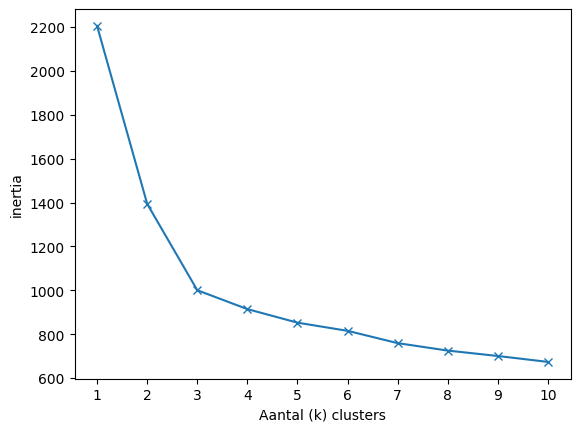

In [40]:
# overgenomen uit ml les
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch, MeanShift
inertia = []
k = range(1, 11)

for i in k:
    model = KMeans(n_clusters=i, n_init=10)

    model.fit(df)

    inertia.append(model.inertia_)

plt.plot(k, inertia, '-x')
plt.xlabel('Aantal (k) clusters')
plt.ylabel('inertia')
plt.xticks(k)
plt.show()

hier kunnen we zien dat het elleboog op het punt k = 3 staat. dit betekent dat de beste aantal clusters 3 is.

In [41]:
data = df
data

,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,rms_energy
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,0.484487,-0.044274,-0.953633,2.103414,-0.223317,0.781341,-0.632439,0.962736,-1.800266,0.799924,...,1.488357,-1.685313,1.456281,-0.998005,0.946166,-1.056823,-0.207066,-0.931777,-0.564025,-0.005254
m00012.wav,1.074915,-0.669653,-0.886789,1.719003,-1.585550,1.483047,-1.130237,1.147159,-0.935620,1.774594,...,2.138239,-1.147957,1.455962,-1.687407,0.978573,-1.410926,0.791126,-1.127938,2.264119,0.947308
m00013.wav,-1.017818,0.067205,-0.995640,0.621481,-1.067151,0.774544,-1.143036,0.989746,-0.158202,1.003829,...,-0.412775,-1.571745,1.161850,2.019628,1.386236,1.711168,1.906329,-1.119986,0.345629,-1.262254
m00043.wav,0.208774,-0.197937,-1.140219,2.280413,-0.269944,1.218515,-0.539675,1.649282,-1.265517,0.965347,...,1.455360,-0.839766,0.583486,-2.030792,-0.064569,-1.739159,-1.276788,-0.597140,-1.208862,-0.425318
m00044.wav,-2.116991,1.823785,0.808667,-1.562392,0.138805,-1.570094,-0.993139,-1.095278,-0.188952,-1.840896,...,-1.535570,-0.520888,-1.476433,-0.772143,-2.032423,-0.949490,-1.563988,-0.824574,-1.297411,-1.382571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m00971.wav,-0.715169,1.277592,-1.274369,-0.838470,-0.847983,-0.982974,-0.438186,-1.385951,-0.626994,-1.676399,...,-1.169117,0.266517,-1.033799,-0.788557,-1.524159,-0.307250,-1.304866,0.083990,0.042968,-1.147540
m00973.wav,1.026510,-1.137606,1.381634,-0.765037,0.936434,-0.155219,1.402402,0.072683,0.612714,-0.110127,...,-0.286592,0.372095,-0.688077,-0.027707,-1.121709,0.675465,-0.429937,1.430338,0.745321,1.444242
m00988.wav,0.678009,-1.588808,1.001067,-1.726364,0.406427,-0.215518,0.647399,-0.092322,1.506906,0.000735,...,0.254812,0.771619,0.368334,0.616372,-0.944779,0.066290,-0.901796,-1.066126,-1.140235,1.222169


# Fantasy Cup Spelers Dataset

| Player    | Speed    | Defence     | Pas    | Shot     | Creativeness |
|-----------|----------|-------------|--------|----------|--------------|
| Vikram    | 90       | 70          | 80     | 75       | 85           |
| Bob       | 60       | 90          | 50     | 40       | 50           |
| Mark      | 80       | 65          | 90     | 70       | 80           |
| Sami      | 95       | 40          | 60     | 85       | 70           |
| Daan      | -        | 85          | -      | -        | -            |
| Penaldo   | 75       | 30          | 60     | 95       | 40           |
| Pessi     | 70       | 50          | 85     | 60       | 90           |




# Initialization:

Choose the number of clusters (K) that you want to create in your dataset.
Randomly initialize K cluster centroids. These centroids represent the initial centers of the clusters.
Assignment Step:

For each data point in the dataset, calculate the distance to each centroid.
Assign the data point to the cluster whose centroid is the closest using Euclidean distance,

Recalculate the centroids of each cluster by taking the mean of all data points assigned to that cluster.

Repeat the assignment and update steps until convergence. Convergence occurs when the centroids no longer change significantly or when a certain number of iterations are reached.
Output:

The algorithm outputs K clusters, each represented by its centroid.

note* even though Daan has NaN values he wil stil be asigned to a centroid based on existing features




In [42]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch, MeanShift
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch, MeanShift
from sklearn.preprocessing import StandardScaler
import numpy as np

class Clustering:
    def __init__(self, data):
        """
        Initializes the Clustering object with input data.

        Parameters:
        - data (numpy.ndarray): Input data for clustering.
        """
        self.data = data
        self.cluster_labels = None



        def calculate_silhouette_score(self):
            if self.cluster_labels is not None:
                if len(np.unique(self.cluster_labels)) > 1:
                    self.silhouette_score = silhouette_score(self.data, self.cluster_labels)
                else:
                    print("Silhouette score cannot be calculated with only one cluster.")
            else:
                print("Cluster labels not available. Run a clustering algorithm first.")

    def cluster_kmeans(self, n_clusters=3):
        """
        Performs KMeans clustering on the input data.

        Parameters:
        - n_clusters (int): Number of clusters.

        Returns:
        - numpy.ndarray: An array containing the input data and assigned cluster labels.
        """
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.cluster_labels = kmeans.fit_predict(self.data)
        return np.column_stack((self.data, self.cluster_labels))

    def cluster_agglomerative(self, n_clusters=3):
        """
        Performs Agglomerative clustering on the input data.

        Parameters:
        - n_clusters (int): Number of clusters.

        Returns:
        - numpy.ndarray: An array containing the input data and assigned cluster labels.
        """
        agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
        self.cluster_labels = agglomerative.fit_predict(self.data)
        return np.column_stack((self.data, self.cluster_labels))

    def cluster_dbscan(self, eps=0.5, min_samples=5):
        """
        Performs DBSCAN clustering on the input data.

        Parameters:
        - eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        - min_samples (int): The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.

        Returns:
        - numpy.ndarray: An array containing the input data and assigned cluster labels.
        """
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        self.cluster_labels = dbscan.fit_predict(self.data)
        return np.column_stack((self.data, self.cluster_labels))

    def cluster_birch(self, n_clusters=3):
        """
        Performs Birch clustering on the input data.

        Parameters:
        - n_clusters (int): Number of clusters.

        Returns:
        - numpy.ndarray: An array containing the input data and assigned cluster labels.
        """
        birch = Birch(n_clusters=n_clusters)
        self.cluster_labels = birch.fit_predict(self.data)
        return np.column_stack((self.data, self.cluster_labels))

    def cluster_meanshift(self, bandwidth=0.5):
        """
        Performs MeanShift clustering on the input data.

        Parameters:
        - bandwidth (float): Bandwidth parameter for MeanShift.

        Returns:
        - numpy.ndarray: An array containing the input data and assigned cluster labels.
        """
        meanshift = MeanShift(bandwidth=bandwidth)
        self.cluster_labels = meanshift.fit_predict(self.data)
        return np.column_stack((self.data, self.cluster_labels))


In [44]:
unlabeled_data = data
unlabeled_data

,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,rms_energy
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,0.484487,-0.044274,-0.953633,2.103414,-0.223317,0.781341,-0.632439,0.962736,-1.800266,0.799924,...,1.488357,-1.685313,1.456281,-0.998005,0.946166,-1.056823,-0.207066,-0.931777,-0.564025,-0.005254
m00012.wav,1.074915,-0.669653,-0.886789,1.719003,-1.585550,1.483047,-1.130237,1.147159,-0.935620,1.774594,...,2.138239,-1.147957,1.455962,-1.687407,0.978573,-1.410926,0.791126,-1.127938,2.264119,0.947308
m00013.wav,-1.017818,0.067205,-0.995640,0.621481,-1.067151,0.774544,-1.143036,0.989746,-0.158202,1.003829,...,-0.412775,-1.571745,1.161850,2.019628,1.386236,1.711168,1.906329,-1.119986,0.345629,-1.262254
m00043.wav,0.208774,-0.197937,-1.140219,2.280413,-0.269944,1.218515,-0.539675,1.649282,-1.265517,0.965347,...,1.455360,-0.839766,0.583486,-2.030792,-0.064569,-1.739159,-1.276788,-0.597140,-1.208862,-0.425318
m00044.wav,-2.116991,1.823785,0.808667,-1.562392,0.138805,-1.570094,-0.993139,-1.095278,-0.188952,-1.840896,...,-1.535570,-0.520888,-1.476433,-0.772143,-2.032423,-0.949490,-1.563988,-0.824574,-1.297411,-1.382571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m00971.wav,-0.715169,1.277592,-1.274369,-0.838470,-0.847983,-0.982974,-0.438186,-1.385951,-0.626994,-1.676399,...,-1.169117,0.266517,-1.033799,-0.788557,-1.524159,-0.307250,-1.304866,0.083990,0.042968,-1.147540
m00973.wav,1.026510,-1.137606,1.381634,-0.765037,0.936434,-0.155219,1.402402,0.072683,0.612714,-0.110127,...,-0.286592,0.372095,-0.688077,-0.027707,-1.121709,0.675465,-0.429937,1.430338,0.745321,1.444242
m00988.wav,0.678009,-1.588808,1.001067,-1.726364,0.406427,-0.215518,0.647399,-0.092322,1.506906,0.000735,...,0.254812,0.771619,0.368334,0.616372,-0.944779,0.066290,-0.901796,-1.066126,-1.140235,1.222169


In [45]:
from sklearn.cluster import KMeans


k = 3  

kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)

unlabeled_data['cluster'] = kmeans.fit_predict(unlabeled_data)

print(unlabeled_data['cluster'].value_counts())

cluster
2    40
0    39
1    26
Name: count, dtype: int64


hier voeren we Kmeans op de unlabeled dataset en voegen de clusters toe als kolommen.

In [46]:
unlabeled_cluster = unlabeled_data.groupby('cluster').agg('mean')

display(unlabeled_cluster)


,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,rms_energy
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.662629,-0.841906,1.037256,-0.656643,0.914727,-0.264323,1.049141,-0.293909,1.039854,-0.220093,...,-0.389207,0.581923,-0.417337,0.447544,-0.555263,0.279848,-0.270828,0.565347,0.130566,0.809423
1,0.679839,-0.374423,-0.767721,1.499267,-1.050988,1.426347,-0.812442,1.467305,-0.984872,1.321413,...,1.417565,-1.284955,1.205482,-1.293657,0.765812,-1.213938,0.413855,-1.034676,0.162882,0.302546
2,-1.087959,1.064233,-0.512306,-0.334297,-0.208717,-0.669411,-0.494825,-0.667187,-0.373691,-0.644328,...,-0.541941,0.267846,-0.376660,0.404521,0.043604,0.516208,-0.004948,0.121326,-0.233175,-0.985842


In [47]:
labeled = df1
print(labeled)

      filename      genre  mfcc1_mean  mfcc2_mean  mfcc3_mean  mfcc4_mean  \
0   m00248.wav      metal  -75.517517   81.911423  -22.081079   69.876999   
1   m00230.wav    country  -89.736382   36.286205   11.469535   37.495590   
2   m00637.wav     hiphop -122.780525   95.061287  -29.363251   46.780045   
3   m00627.wav      metal  -57.683388  101.432320  -41.485245   55.130600   
4   m00138.wav     reggae -198.632797  102.413567  -10.031448   30.802383   
5   m00192.wav  classical  -85.264992  118.423058  -31.472771   20.282015   
6   m00429.wav     hiphop -109.509193   97.389565  -20.619621   37.366669   
7   m00623.wav     reggae  -94.140526   68.229942    3.975481    7.631387   
8   m00002.wav       jazz -298.807953  112.078224    6.485770   28.386517   
9   m00039.wav     reggae -169.243668  110.447716   -8.553957   43.898693   
10  m00677.wav    country -139.623062  128.793533  -20.249359   49.443615   
11  m00867.wav       rock -142.442062  116.238441  -32.190319   49.114605   

In [48]:
label_scaled = scaler(labeled)

label_scaled['genre'] = labeled['genre']

label_scaled = label_scaled.groupby('genre').agg('mean', numeric_only=True)
# Drop 'index' en 'sfreq' kolommen

display(label_scaled)


,mfcc10_mean,mfcc11_mean,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,...,mfcc20_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,rms_energy
genre,,,,,,,,,,,,,,,,,,,,,
blues,0.004038,0.118024,0.021959,-0.428812,-0.205446,0.118079,-0.220060,-0.213902,-0.242380,0.199602,...,-0.505011,0.918134,0.243213,0.556125,0.184838,0.188702,0.039634,0.233437,0.177360,0.445559
classical,-1.114347,0.160960,-0.859439,0.498216,-0.840703,0.296087,-0.226096,0.681501,-0.487632,0.608626,...,1.323335,1.129615,-0.713336,-0.805599,0.187766,-1.129266,-0.087103,-1.427242,0.067154,-1.175339
country,-0.242489,-0.552423,-0.230708,-0.243896,-0.280475,0.124373,0.079919,-0.328026,0.133802,0.007894,...,-0.454321,0.290692,0.339520,0.307473,-0.060878,-0.226583,-0.192221,-0.180159,-0.517528,0.254206
disco,0.006726,0.561260,-0.521908,0.581411,-0.270363,0.334442,-0.357960,0.356380,0.207025,0.373142,...,-0.216592,-0.543266,0.305322,-0.784594,0.532762,-0.148738,0.742088,-0.372970,0.710443,0.556156
hiphop,1.371572,-0.380498,1.381152,0.076292,1.299161,-0.167654,1.292157,0.235716,0.454815,-0.126637,...,0.260917,-0.543491,-0.585650,0.695697,-0.667020,1.422759,-0.765019,1.277316,-0.152469,-0.100621
jazz,-0.128447,0.234577,-0.084934,0.245028,0.526613,0.240145,0.351777,0.631660,-0.076951,0.644857,...,-0.385368,0.634218,0.095933,0.260028,-0.483867,-0.147716,-0.247177,-0.249819,0.062708,-0.766631
metal,1.086216,-0.932118,0.890632,-1.400214,0.402003,-1.212095,0.970990,-0.904184,0.553568,-0.823810,...,0.318826,-0.433774,-0.932222,1.311820,-1.029750,1.069734,-0.735267,1.189815,-0.881726,0.065198
pop,-0.801638,0.879597,-0.987921,1.089878,-0.501327,0.457081,-0.888235,0.635822,-0.409927,0.517911,...,-0.151191,-1.110467,0.967487,-1.477903,0.636546,-1.024685,0.956033,-0.852722,0.912750,1.224540
reggae,-0.023831,0.590266,0.147729,0.396603,0.208611,0.385449,-0.342643,0.275791,0.327933,0.159211,...,0.378747,-0.205456,0.606452,-0.312523,0.886485,-0.179706,0.637009,0.191636,0.335474,-0.396512


In [49]:
from scipy.spatial.distance import euclidean

def bereken_afstanden(genre_data, cluster_data):
    afstanden = []

    for genre_row in genre_data.iterrows():
        genre_name, genre_values = genre_row
        for cluster_row in cluster_data.iterrows():
            cluster_name, cluster_values = cluster_row
            distance = euclidean(genre_values, cluster_values)
            afstanden.append((genre_name, cluster_name, distance))

    return afstanden

afstanden = bereken_afstanden(label_scaled, unlabeled_cluster)

for genre_name, cluster_name, distance in afstanden:
    print(f"Afstand tussen {genre_name} en {cluster_name}: {distance}")

Afstand tussen blues en 0: 3.122211217880249
Afstand tussen blues en 1: 5.477787971496582
Afstand tussen blues en 2: 2.6923463344573975
Afstand tussen classical en 0: 6.213770389556885
Afstand tussen classical en 1: 4.528794288635254
Afstand tussen classical en 2: 4.4373650550842285
Afstand tussen country en 0: 2.9613358974456787
Afstand tussen country en 1: 5.261229515075684
Afstand tussen country en 2: 2.8489413261413574
Afstand tussen disco en 0: 4.317814350128174
Afstand tussen disco en 1: 4.061002254486084
Afstand tussen disco en 2: 3.664933681488037
Afstand tussen hiphop en 0: 2.661475896835327
Afstand tussen hiphop en 1: 7.239708423614502
Afstand tussen hiphop en 2: 5.005178451538086
Afstand tussen jazz en 0: 3.652494192123413
Afstand tussen jazz en 1: 5.086965560913086
Afstand tussen jazz en 2: 3.08872652053833
Afstand tussen metal en 0: 2.912313938140869
Afstand tussen metal en 1: 8.28516674041748
Afstand tussen metal en 2: 4.815219879150391
Afstand tussen pop en 0: 6.16603040

In [50]:
from scipy.spatial.distance import cityblock

def bereken_manhattan_afstanden(genre_data, cluster_data):
    afstanden = []

    for genre_row in genre_data.iterrows():
        genre_name, genre_values = genre_row
        for cluster_row in cluster_data.iterrows():
            cluster_name, cluster_values = cluster_row
            distance = cityblock(genre_values, cluster_values)
            afstanden.append((genre_name, cluster_name, distance))

    return afstanden

manhattan_afstanden = bereken_manhattan_afstanden(label_scaled, unlabeled_cluster)

for genre_name, cluster_name, distance in manhattan_afstanden:
    print(f"Manhattan-afstand tussen {genre_name} en {cluster_name}: {distance}")

Manhattan-afstand tussen blues en 0: 11.52075481414795
Manhattan-afstand tussen blues en 1: 21.661054611206055
Manhattan-afstand tussen blues en 2: 9.300025939941406
Manhattan-afstand tussen classical en 0: 25.2088565826416
Manhattan-afstand tussen classical en 1: 15.897185325622559
Manhattan-afstand tussen classical en 2: 16.356840133666992
Manhattan-afstand tussen country en 0: 11.349987983703613
Manhattan-afstand tussen country en 1: 21.781166076660156
Manhattan-afstand tussen country en 2: 9.872578620910645
Manhattan-afstand tussen disco en 0: 17.919675827026367
Manhattan-afstand tussen disco en 1: 16.744670867919922
Manhattan-afstand tussen disco en 2: 14.780254364013672
Manhattan-afstand tussen hiphop en 0: 10.353241920471191
Manhattan-afstand tussen hiphop en 1: 29.829498291015625
Manhattan-afstand tussen hiphop en 2: 19.326688766479492
Manhattan-afstand tussen jazz en 0: 13.575538635253906
Manhattan-afstand tussen jazz en 1: 21.33285903930664
Manhattan-afstand tussen jazz en 2:

In [51]:
def bepaal_genres_voor_clusters(genre_data, cluster_data, afstanden_functie):
    toewijzingen = []

    for cluster_row in cluster_data.iterrows():
        cluster_name, cluster_values = cluster_row
        min_afstand = float('inf') 
        op_een_na_min_afstand = float('inf')  
        toegewezen_genre = None
        op_een_na_toegewezen_genre = None

        for genre_row in genre_data.iterrows():
            genre_name, genre_values = genre_row
            afstand = afstanden_functie(genre_values, cluster_values)

            if afstand < min_afstand:
                op_een_na_min_afstand = min_afstand
                op_een_na_toegewezen_genre = toegewezen_genre

                min_afstand = afstand
                toegewezen_genre = genre_name
            elif afstand < op_een_na_min_afstand:
                op_een_na_min_afstand = afstand
                op_een_na_toegewezen_genre = genre_name

        toewijzingen.append((cluster_name, toegewezen_genre, min_afstand, op_een_na_toegewezen_genre, op_een_na_min_afstand))

    return toewijzingen

toewijzingen_euclidisch = bepaal_genres_voor_clusters(label_scaled, unlabeled_cluster, euclidean)

toewijzingen_manhattan = bepaal_genres_voor_clusters(label_scaled, unlabeled_cluster, cityblock)

print("Toewijzingen op basis van Euclidische afstanden:")
for cluster_name, genre_name, afstand, op_een_na_genre, op_een_na_afstand in toewijzingen_euclidisch:
    print(f"Cluster {cluster_name} is toegewezen aan genre {genre_name} met een afstand {afstand}. Op één na dichtstbijzijnde genre: {op_een_na_genre} met een afstand {op_een_na_afstand}")

print("\nToewijzingen op basis van Manhattan-afstanden:")
for cluster_name, genre_name, afstand, op_een_na_genre, op_een_na_afstand in toewijzingen_manhattan:
    print(f"Cluster {cluster_name} is toegewezen aan genre {genre_name} met een afstand {afstand}. Op één na dichtstbijzijnde genre: {op_een_na_genre} met een afstand {op_een_na_afstand}")

Toewijzingen op basis van Euclidische afstanden:
Cluster 0 is toegewezen aan genre hiphop met een afstand 2.661475896835327. Op één na dichtstbijzijnde genre: metal met een afstand 2.912313938140869
Cluster 1 is toegewezen aan genre pop met een afstand 3.814103603363037. Op één na dichtstbijzijnde genre: disco met een afstand 4.061002254486084
Cluster 2 is toegewezen aan genre blues met een afstand 2.6923463344573975. Op één na dichtstbijzijnde genre: rock met een afstand 2.7802834510803223

Toewijzingen op basis van Manhattan-afstanden:
Cluster 0 is toegewezen aan genre hiphop met een afstand 10.353241920471191. Op één na dichtstbijzijnde genre: country met een afstand 11.349987983703613
Cluster 1 is toegewezen aan genre pop met een afstand 13.859451293945312. Op één na dichtstbijzijnde genre: classical met een afstand 15.897185325622559
Cluster 2 is toegewezen aan genre blues met een afstand 9.300025939941406. Op één na dichtstbijzijnde genre: rock met een afstand 9.35905647277832


In [58]:
def plot_vis(data1, data2, x, y):


    plt.figure(figsize=(15, 6))

    sns.scatterplot(data=data1,
                    x=x,
                    y=y,
                    hue='cluster',
                    palette='viridis',
                    marker='o',  
                    legend='full')
    
    sns.scatterplot(data=data2,
                    x=x,
                    y=y,
                    hue='genre',
                    marker='D',  
                    legend='full')
    
    plt.title(f'Scatter Plot van {x} en {y} met Cluster- en Genrevergelijking')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


In [59]:
unlabeled_cluster.reset_index(inplace=True)
display(unlabeled_cluster.head())
label_scaled.reset_index(inplace=True)
display(label_scaled.head())

,index,cluster,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,...,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,rms_energy
0,0,0,0.662629,-0.841906,1.037256,-0.656643,0.914727,-0.264323,1.049141,-0.293909,...,-0.389207,0.581923,-0.417337,0.447544,-0.555263,0.279848,-0.270828,0.565347,0.130566,0.809423
1,1,1,0.679839,-0.374423,-0.767721,1.499267,-1.050988,1.426347,-0.812442,1.467305,...,1.417565,-1.284955,1.205482,-1.293657,0.765812,-1.213938,0.413855,-1.034676,0.162882,0.302546
2,2,2,-1.087959,1.064233,-0.512306,-0.334297,-0.208717,-0.669411,-0.494825,-0.667187,...,-0.541941,0.267846,-0.376660,0.404521,0.043604,0.516208,-0.004948,0.121326,-0.233175,-0.985842


,level_0,index,genre,mfcc10_mean,mfcc11_mean,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,...,mfcc20_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,rms_energy
0,0,0,blues,0.004038,0.118024,0.021959,-0.428812,-0.205446,0.118079,-0.220060,...,-0.505011,0.918134,0.243213,0.556125,0.184838,0.188702,0.039634,0.233437,0.177360,0.445559
1,1,1,classical,-1.114347,0.160960,-0.859439,0.498216,-0.840703,0.296087,-0.226096,...,1.323335,1.129615,-0.713336,-0.805599,0.187766,-1.129266,-0.087103,-1.427242,0.067154,-1.175339
2,2,2,country,-0.242489,-0.552423,-0.230708,-0.243896,-0.280475,0.124373,0.079919,...,-0.454321,0.290692,0.339520,0.307473,-0.060878,-0.226583,-0.192221,-0.180159,-0.517528,0.254206
3,3,3,disco,0.006726,0.561260,-0.521908,0.581411,-0.270363,0.334442,-0.357960,...,-0.216592,-0.543266,0.305322,-0.784594,0.532762,-0.148738,0.742088,-0.372970,0.710443,0.556156
4,4,4,hiphop,1.371572,-0.380498,1.381152,0.076292,1.299161,-0.167654,1.292157,...,0.260917,-0.543491,-0.585650,0.695697,-0.667020,1.422759,-0.765019,1.277316,-0.152469,-0.100621


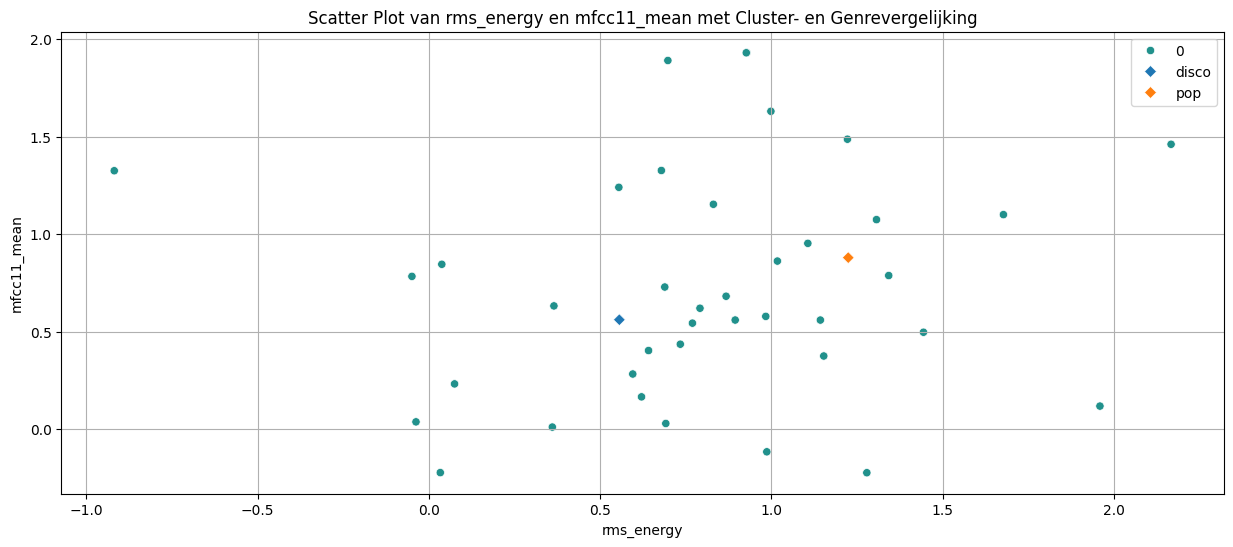

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

clusters = [0]

genres = ['disco', 'pop']


x = 'rms_energy'
y = 'mfcc11_mean'

plot_vis(
    data1=unlabeled_data[unlabeled_data['cluster'].isin(clusters)],
    data2=label_scaled[label_scaled['genre'].isin(genres)],
    x=x,
    y=y
)


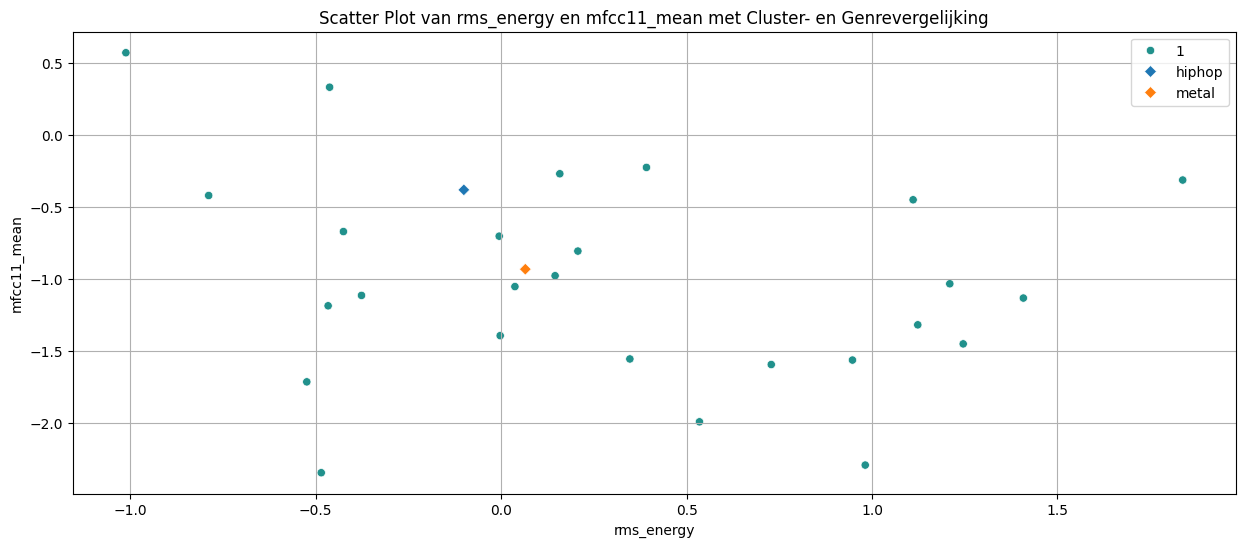

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

clusters = [1]

genres = ['metal', 'hiphop']

plot_vis(
    data1=unlabeled_data[unlabeled_data['cluster'].isin(clusters)],
    data2=label_scaled[label_scaled['genre'].isin(genres)],
    x=x,
    y=y
)

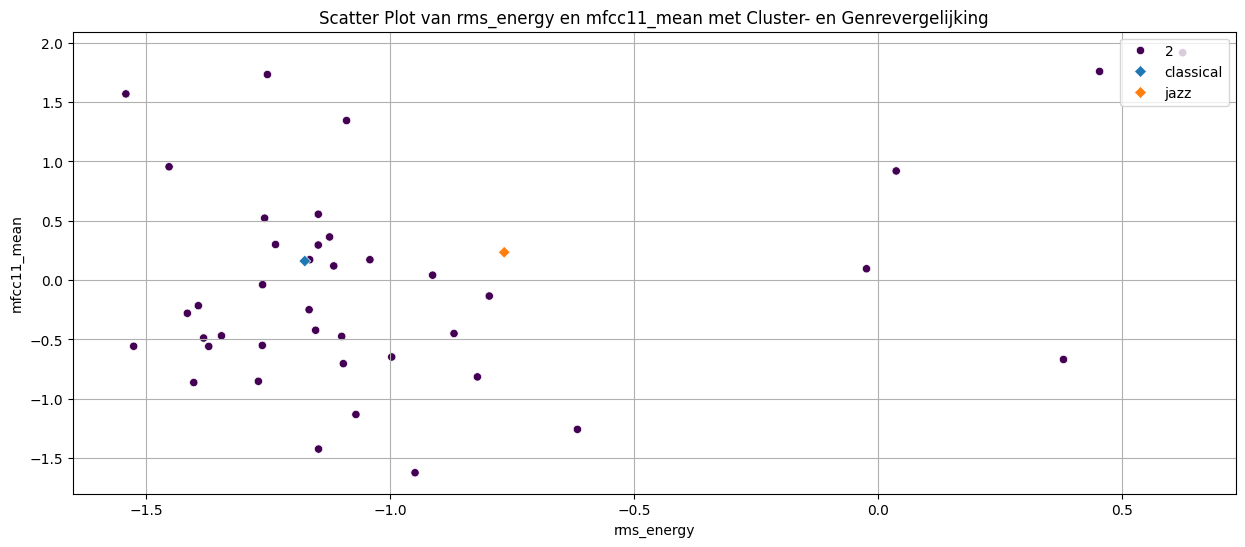

In [57]:
clusters = [2]

genres = ['jazz', 'classical']

x = 'rms_energy'
y = 'mfcc11_mean'

plot_vis(
    data1=unlabeled_data[unlabeled_data['cluster'].isin(clusters)],
    data2=label_scaled[label_scaled['genre'].isin(genres)],
    x=x,
    y=y
)

# PCA Voorbeeld

Om een voorbeeld te geven van het uitvoeren van PCA hebben we eerst een dataset nodig. Voor het gemak maken wij gebruik van een kleine zelf verzonnen dataset.
|       |   X1   |   X2   |
|-------|:-----:|:-----:|
|   1   |   4   |   1   |
|   2   |   2   |   3   |
|   3   |   7   |   6   |
|   4   |   5   |   4   |
|   5   |   9   |   8   |


## Stap 1: Standaardiseren

De eerste stap voor het uitvoeren van PCA is het standaardiseren van de bovenstaande dataset. Dit doen wij aan de hand van de formule voor de Z-score. $$
Z = \frac{{X - \mu}}{{\sigma}}
$$

Door het toepassen van de Z-score krijgen wij de volgende gestandaardiseerde dataset:

|   | xz1  | xz2  |
|---|---------|---------|
| 1 | -0.6325 | -1.2649 |
| 2 | -1.2649 | 0       |
| 3 | 0.6325  | 0.6325  |
| 4 | 0       | -0.6325 |
| 5 | 1.8974  | 1.2649  |


## Stap 2: Covariantiematrix
Vervolgen bereken wij de covariantie matrix van de gestandaardiseerde dataset. Dit doen wij aan de hand van de volgende formule:

$$
Cov(X_i, X_j) = \frac{\sum_{k=1}^{n}(X_i^k - \bar{X_i})(X_j^k - \bar{X_j})}{n-1}
$$

Wanneer wij de bovenstaande formule toepassen krijgen wij het volgende matrix:

\begin{bmatrix} 6.75 & 0.5 \\ 0.5 & 5.0 \end{bmatrix}






## Stap 3: Eigenwaarden en Eigenvectoren
In stap 3 berekenen wij de eigenwaarden en eigenvectoren.

Eigenwaarden:
\begin{align*}
\lambda_1 &= 1.9 \\
\lambda_2 &= 0.8
\end{align*}



Eigenvectoren:
\begin{align*}
v_1 &= \begin{bmatrix} 0.84 \\ 
0.54 \end{bmatrix} \quad (\text{bij } \lambda_1) \\
v_2 &= \begin{bmatrix} -0.54 \\
0.84 \end{bmatrix} \quad (\text{bij } \lambda_2)
\end{align*}


## Stap 4: Feature vector
Wanneer we kijken naar stap 3 zien we dat vector 1 de meeste significantie heeft, dit is dus de vector met de hoogste eigenwaarde. We selecteren daarom v1 als ons eerst principal component. 
v_1 &= \begin{bmatrix} 0.84 \\ 
0.54 \end{bmatrix} 


## Stap 5: Projectie
Voor stap 5 gaan we de gestandaardiseerde gegevens vermenigvuldigen met de gekozen feature vector. Vervolgens krijgen de nieuwe dataset:
$$[-0.6325, -1.2649, -1.2649, 0.6325, 0.6325] \cdot [0.84, 0.54] = [-1.6326, -1.2649, -0.0810, 2.6305] $$
Zo komen wij tot een nieuwe dataset die is gereduceerd tot één dimensie, de eerste principale component.

|                       | Nieuwe Dataset |
|-----------------------|-----------------|
|           1           |     -1.6326     |
|           2           |     -1.2649     |
|           3           |     -0.0810     |
|           4           |      2.6305     |





Voor het uitvoeren van een simpele PCA hebben wij de stappen gevolgd die beschreven staan in het volgende artikel. (Jaadi, 2023) 

Nu dat wij een voorbeeld hebben gegeven van een simpele principal componenent analyse gaan wij dit nu uitvoeren op onze eigen dataset.


In [62]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Stap 1: Standaardiseren
#De data is eerder al gestandaardiseerd. Deze data kunnen we hier hergebruiken
scaled_df = data

In [63]:
# Stap 2: Covariantiematrix
# We maken een covariantiematrix aan de hand van no.cov
cov_matrix = np.cov(scaled_df, rowvar=False)

In [64]:
# Stap 3: Eigenwaarden en Eigenvectoren
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Nu sorteren wij de waardes
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]


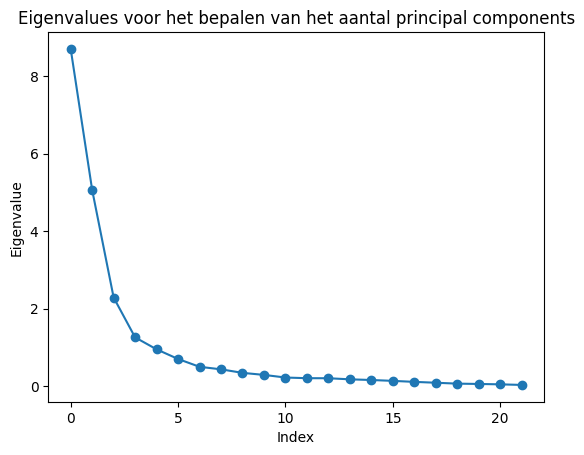

In [65]:
# Aantal principal compponents kiezen
plt.plot(eigenvalues, marker='o')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues voor het bepalen van het aantal principal components')
plt.show()


In [66]:
# Stap 4: Feature vector
pca_num = 3
principal_components = eigenvectors[:, -pca_num:]




In [67]:
# Stap 5: Projectie
pca = PCA(n_components=pca_num)
data_pca = pca.fit_transform(scaled_df)


In [69]:
# Resultaten toevoegen aan dataframe
unlabeld_new = unlabeled_data.copy()
for i in range(pca_num):
    unlabeld_new[f'PC{i+1}'] = data_pca[:, i]

In [70]:
# Toon het resultaat
display(unlabeled_data.head())


,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,rms_energy,cluster
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,0.484487,-0.044274,-0.953633,2.103414,-0.223317,0.781341,-0.632439,0.962736,-1.800266,0.799924,...,-1.685313,1.456281,-0.998005,0.946166,-1.056823,-0.207066,-0.931777,-0.564025,-0.005254,1
m00012.wav,1.074915,-0.669653,-0.886789,1.719003,-1.585550,1.483047,-1.130237,1.147159,-0.935620,1.774594,...,-1.147957,1.455962,-1.687407,0.978573,-1.410926,0.791126,-1.127938,2.264119,0.947308,1
m00013.wav,-1.017818,0.067205,-0.995640,0.621481,-1.067151,0.774544,-1.143036,0.989746,-0.158202,1.003829,...,-1.571745,1.161850,2.019628,1.386236,1.711168,1.906329,-1.119986,0.345629,-1.262254,2
m00043.wav,0.208774,-0.197937,-1.140219,2.280413,-0.269944,1.218515,-0.539675,1.649282,-1.265517,0.965347,...,-0.839766,0.583486,-2.030792,-0.064569,-1.739159,-1.276788,-0.597140,-1.208862,-0.425318,1
m00044.wav,-2.116991,1.823785,0.808667,-1.562392,0.138805,-1.570094,-0.993139,-1.095278,-0.188952,-1.840896,...,-0.520888,-1.476433,-0.772143,-2.032423,-0.949490,-1.563988,-0.824574,-1.297411,-1.382571,2


In [ ]:
#PCA toevoegen aan dataset
df_pca = scaled_df.copy()
for i in range(pca_num):
    df_pca[f'PC{i+1}'] = data_pca[:, i]

In [ ]:
pca_df = df_pca[['PC1', 'PC2', 'PC3']]


In [ ]:
#Getransformeerde dataset
display(pca_df.head())

Bronnen:
Bronnen lijst PCA Daan
Wikipedia-bijdragers. (2023, 31 juli). Hoofdcomponentenanalyse. Wikipedia. Geraadpleegd op 21-1-2024 van https://nl.wikipedia.org/wiki/Hoofdcomponentenanalyse 
Jaadi, Z. (2023, 29 maart). A Step-by-Step Explanation of Principal Component Analysis (PCA). Built In. Geraadpleegd op 21-1-2024 van https://builtin.com/data-science/step-step-explanation-principal-component-analysis
Beat and Tempo — Librosa 0.10.1 Documentation. (z.d.). https://librosa.org/doc/latest/beat.html
Filters — Librosa 0.10.1 documentation. (z.d.). https://librosa.org/doc/latest/filters.html#filter-bank-construction
Librosa.feature.spectral_centroid — Librosa 0.10.1 documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.spectral_centroid.html
Librosa.feature.spectral_bandwidth — Librosa 0.10.1 Documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.spectral_bandwidth.html
Librosa.feature.spectral_flatness — Librosa 0.10.1 Documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.spectral_flatness.html
Librosa.feature.spectral_rolloff — Librosa 0.10.1 Documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.spectral_rolloff.html
Librosa.feature.tonnetz — Librosa 0.10.1 Documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.tonnetz.html
Librosa.feature.zero_crossing_rate — Librosa 0.10.1 Documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.zero_crossing_rate.html
Librosa.feature.Tempogram — Librosa 0.10.1 documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.tempogram.html
Scipy.spatial.distance.cityblock — SciPY v1.12.0 Manual. (z.d.). https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cityblock.html
Scipy.spatial.distance.euclidean — SciPY v1.12.0 manual. (z.d.). https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html
Scipy.spatial.distance.euclidean — SciPY v1.12.0 manual. (z.d.-b). https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html
Scipy.spatial.distance.cityblock — SciPY v1.12.0 Manual. (z.d.-b). https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cityblock.html



# Feature run probleem
Extract other features using the AudioFeatureExtractor class
            spectrograms, _ = audio_extractor.calculate_spectrograms([data])
            bandwidths, centroids = audio_extractor.calculate_spectral_features(spectrograms)
            spectral_contrast = audio_extractor.calculate_spectral_contrast(data, sfreq)
            tonnetz = audio_extractor.calculate_tonnetz(data, sfreq)
            spectral_rolloff = audio_extractor.calculate_spectral_rolloff(data, sfreq)
            chroma_features = audio_extractor.calculate_chroma_features(data, sfreq)
            mel_spectral_contrast = audio_extractor.calculate_mel_spectral_contrast(data, sfreq)
            spectral_flatness = audio_extractor.calculate_spectral_flatness(data, sfreq)
            zcr = audio_extractor.zero_crossing_rate_features(data)
            tempogram_result = audio_extractor.calculatetempogram(data, sfreq)
            f0, , _ = audio_extractor.calculate_polyphonic_pitch(data, sfreq)
            rms_energy = audio_extractor.rms_energy_features(data)

            # Combine all features into a dictionary
            features_dict = {
                **mfcc_features,
                'mean_bandwidth': np.mean(bandwidths),
                # ... (add other features to the dictionary)
                'tempogram_result': tempogram_result,
                'polyphonic_pitch': f0,
                'rms_energy': r

                We hebben deze features niet kunnen runnen omdat de notebook na 24 uur laden het nog niet was geladen, hierdoor hebben we sommige delen minder accuraat kunnen doen
                